In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table
from preprocessing import process_vital_signs, process_diagnoses

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # Connect to MIMIC-III dataset
# con = create_connection()

### Vital Signs monitored each hour for the 1st day of admission

In [4]:
# script = query_sql_file('../sql_scripts/vital_signs/vital_signs_per_hour.sql', con)
# original_df = query_data(script[0], con)
# original_df.head()

#### Pre-process

In [5]:
# # remove entries where no vital id is specified
# original_df.dropna(subset=['vitalid'], inplace=True)
#
# # assign actual vital sign label to each vital id
# original_df = process_vital_signs.replace_vital_labels(original_df)
#
# # # remove vital id feature
# # df.drop(columns=['vitalid'], inplace=True)
# original_df.head()

In [6]:
# # Get the admission time for each hadm_id
# query = \
# """
# SELECT hadm_id, admittime, hospital_expire_flag
# FROM admissions;
# """
# admissions = query_data(query, con)

In [7]:
# original_df = pd.merge(original_df, admissions, on=['hadm_id'], how='left')
# original_df.head()

In [8]:
# ### Calculate the hour since admission instead of the actual datetime
# original_df['hours_since_admission'] = (original_df['chart_hour'] - original_df['admittime']).dt.total_seconds() // 3600
#
# original_df.drop(columns=['chart_hour', 'admittime'], inplace=True)
#
# ### For multiple monitored signs per hour, take the average
# df = original_df.groupby(['hadm_id', 'icustay_id', 'vitalid', 'vital_sign', 'hours_since_admission'], as_index=False).agg({
#     'valuenum': 'mean',
#     'hospital_expire_flag': 'max'
# })
# df['hours_since_admission'] = df['hours_since_admission'].astype('int')
# df.head()

In [9]:
# df.to_csv('../dataset/vital_signs_per_hour.csv')
df = pd.read_csv('../dataset/vital_signs_per_hour.csv')

In [10]:
df.head()

,Unnamed: 0,hadm_id,icustay_id,vitalid,vital_sign,hours_since_admission,valuenum,hospital_expire_flag
0,0,100001,275225,1.0,heart_rate,0,122.0,0
1,1,100001,275225,1.0,heart_rate,1,118.0,0
2,2,100001,275225,1.0,heart_rate,2,118.0,0
3,3,100001,275225,1.0,heart_rate,3,110.0,0
4,4,100001,275225,1.0,heart_rate,4,104.0,0


### Correlation Matrix - Vital Signs

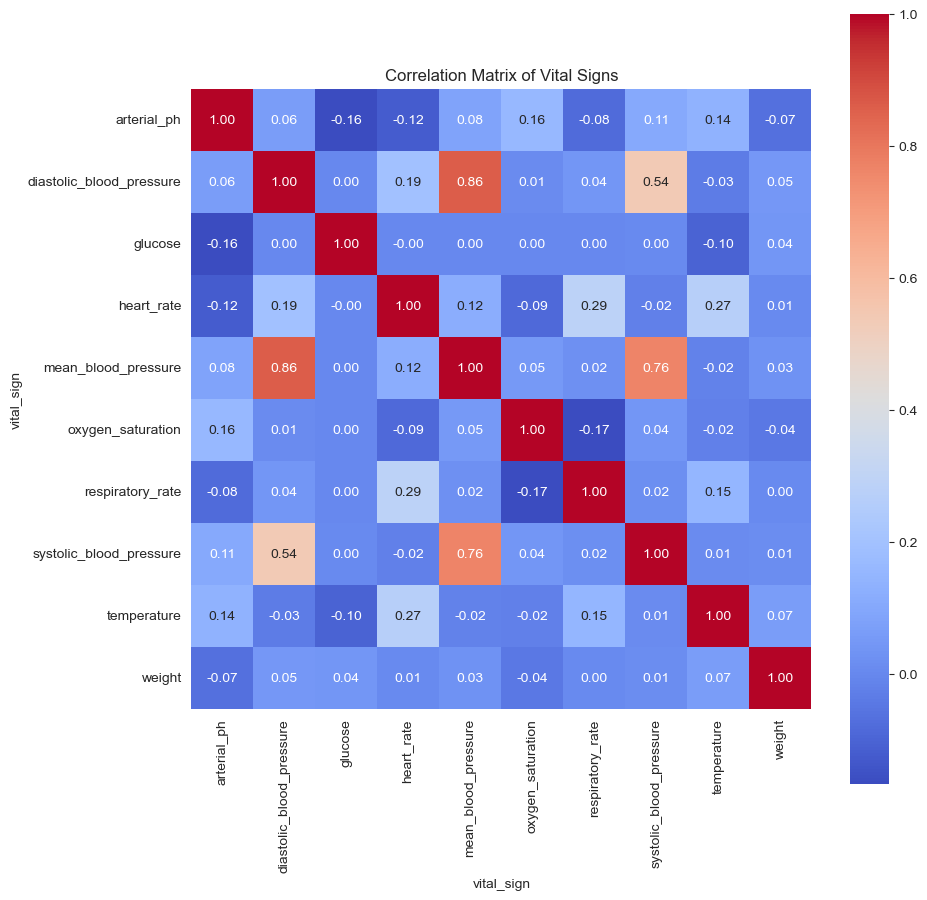

In [11]:
import seaborn as sns

pivot_df = df.pivot_table(index=['hadm_id', 'hours_since_admission'], columns='vital_sign', values='valuenum')
corr_matrix = pivot_df.corr()

# Let's visualize this correlation matrix using a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", square=True, cmap = 'coolwarm')
plt.title("Correlation Matrix of Vital Signs")
plt.show()

### Hospital Mortality based on Vital Signs

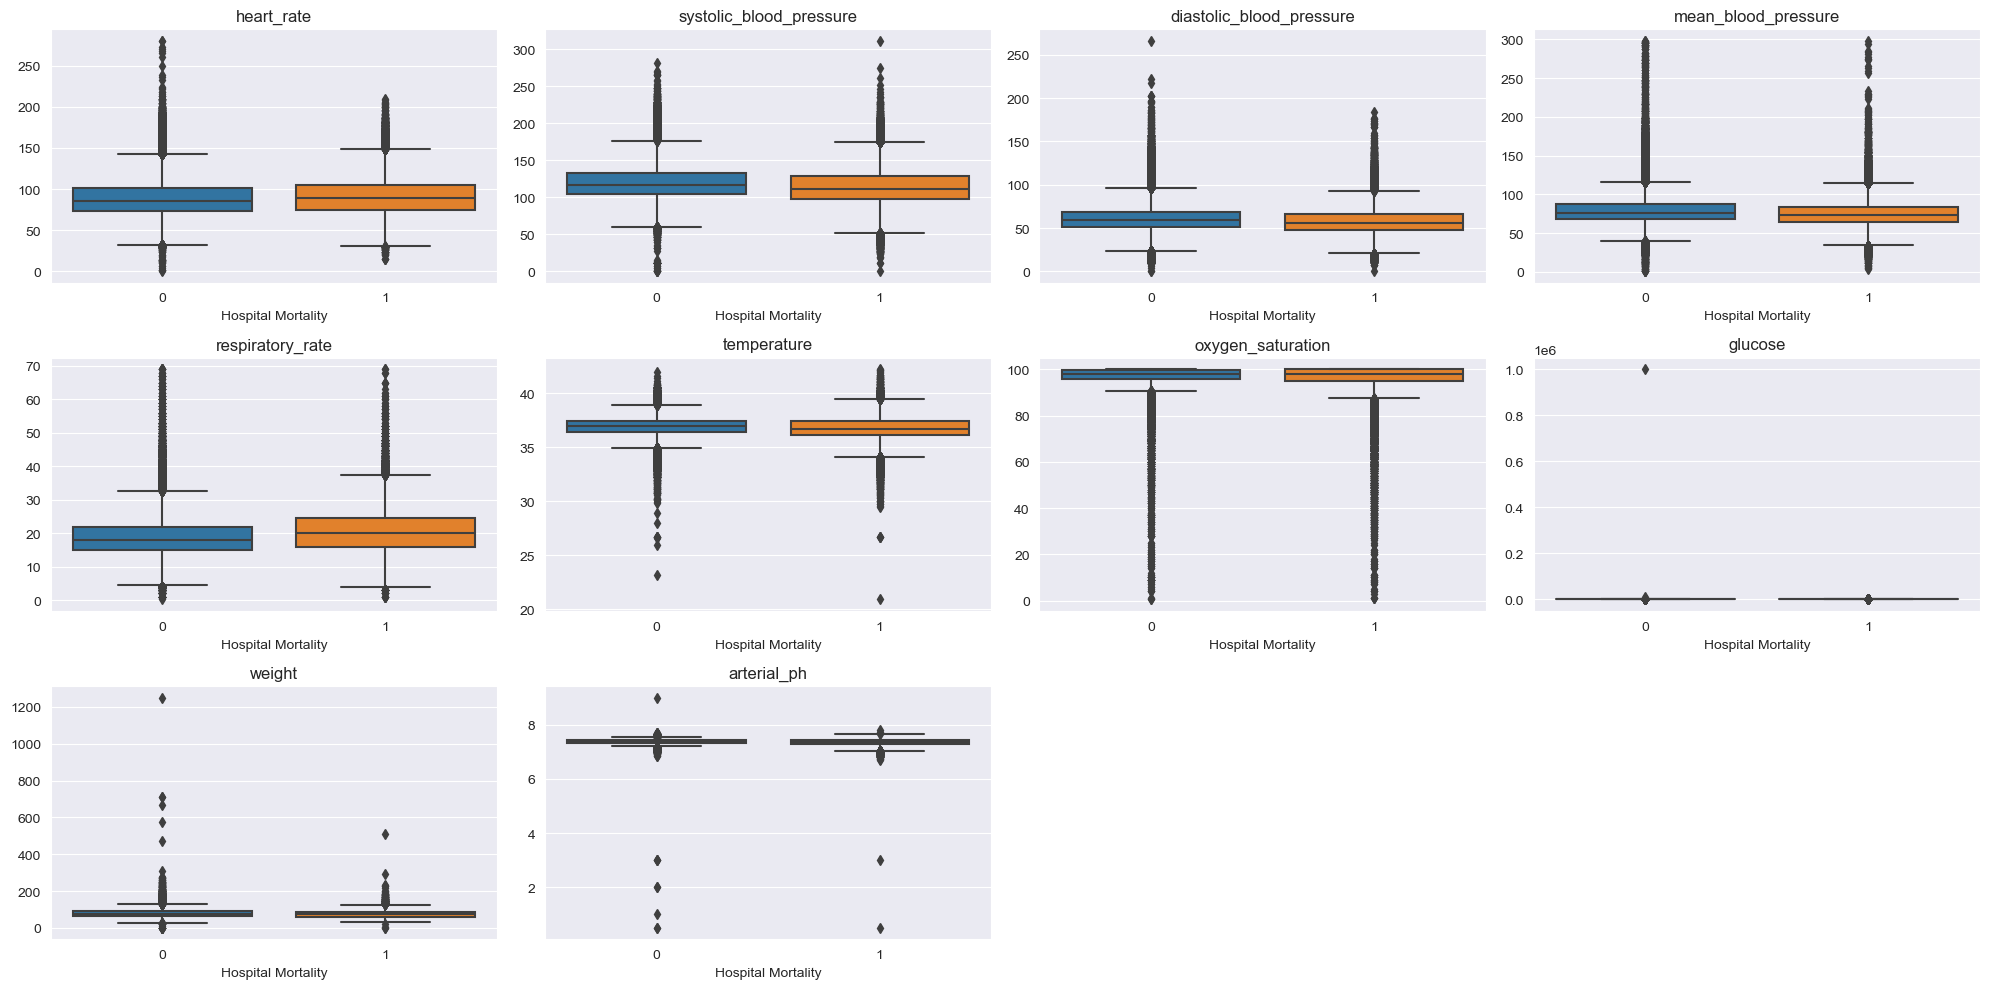

In [12]:
vital_signs = df['vital_sign'].unique()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()

# Plot each vital sign
for ax, vital_sign in zip(axes, vital_signs):
    df_vital = df[df['vital_sign'] == vital_sign]  # filter the DataFrame for the current vital sign
    sns.boxplot(x='hospital_expire_flag', y='valuenum', data=df_vital, ax=ax)  # showfliers=False hides outliers
    ax.set_title(vital_sign)
    ax.set_xlabel('Hospital Mortality')
    ax.set_ylabel('')

# Remove unused subplots
for i in range(len(vital_signs), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data_viz_img/vital_signs_mortality.png')
plt.show()

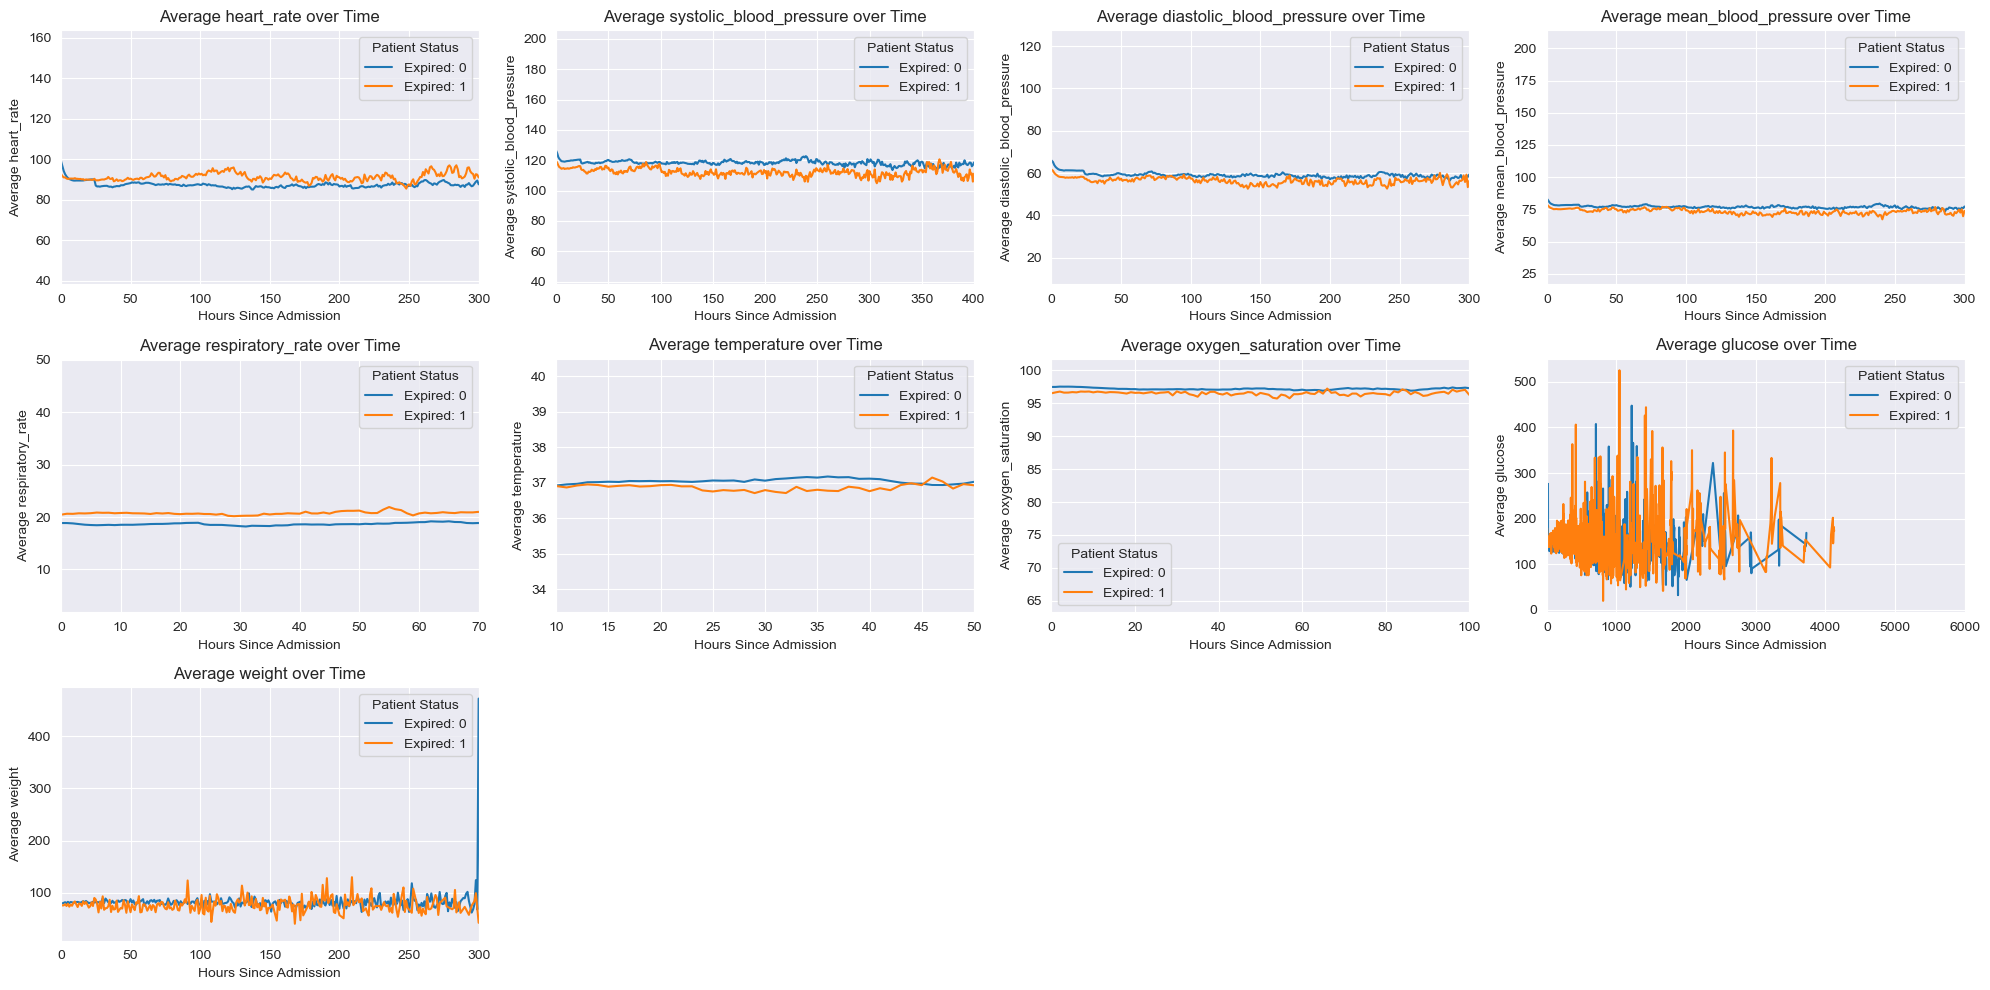

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()

limits = process_vital_signs.define_limits()

for ax, vital_sign in zip(axes, limits):
    df_vital = df[df['vital_sign'] == vital_sign]  # filter the DataFrame for the current vital sign
    grouped_df = df_vital.groupby(['hospital_expire_flag', 'hours_since_admission'])['valuenum'].mean().reset_index()
    for label, group in grouped_df.groupby('hospital_expire_flag'):
        ax.plot(group['hours_since_admission'], group['valuenum'], label=f'Expired: {label}')
    ax.set_title(f"Average {vital_sign} over Time")
    ax.set_xlabel('Hours Since Admission')
    ax.set_ylabel(f'Average {vital_sign}')
    ax.set_xlim(limits[vital_sign])
    ax.legend(title='Patient Status')

for i in range(len(limits), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data_viz_img/vital_signs_over_time.png')
plt.show()

In [ ]:
# process_vital_signs.visualize_over_time(df=df, vital_sign='heart_rate', limits=[0, 300])

In [ ]:
# process_vital_signs.visualize_over_time(df=df, vital_sign='systolic_blood_pressure', limits=[0, 400])

In [ ]:
# # Convert the 'valuenum' column to a list for each hadm_id and vital sign
# df_grouped = df.groupby(['hadm_id', 'vital_sign'])['valuenum'].apply(list).reset_index()
#
# # Pivot the table so that each vital sign becomes a column
# df_pivoted = df_grouped.pivot(index='hadm_id', columns='vital_sign', values='valuenum')
#
# # Reset the index
# df_pivoted.reset_index(inplace=True)
#
# df_pivoted.drop(columns=['arterial_ph', 'weight'], inplace=True)
# df_pivoted.head()

In [ ]:
# df_pivoted.isnull().sum()

In [ ]:
# # df_3d = df.pivot_table(values='valuenum', index=['hadm_id', 'chart_hour'], columns='vital_sign')
# # df_3d

In [ ]:
# patient_data = pd.read_csv('../dataset/patient_stay_data.csv')
# final_df = pd.merge(df_pivoted, patient_data, on='hadm_id', how='left')
# final_df.head()

In [ ]:
# df_pivoted = df_pivoted.drop_duplicates(subset='hadm_id')
# final_df = pd.merge(df_pivoted, patient_data, on='hadm_id', how='left')
# final_df.head()